In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics

import os
import warnings
warnings.filterwarnings("ignore") 

from datetime import datetime, date
from IPython.display import display, Markdown

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_pickle('../data/processed/cleaned_intersections_collisions.pkl')
df = df[((df.PEDCOUNT > 0) | (df.PEDCYLCOUNT > 0)) & (df.VEHCOUNT > 0)]

In [3]:
model_df = df[['COMPKEY', 'LOCATION', 'ARTERIALCLASSCD', 'SIGNAL_TYPE']]

In [4]:
num_collisions = pd.DataFrame(model_df.COMPKEY.value_counts()).reset_index().rename(columns={'index':'COMPKEY','COMPKEY':'num_collisions'})
model_df = model_df[~model_df.duplicated()]

In [5]:
model_df = model_df.merge(num_collisions, on='COMPKEY')

In [6]:
model_df.pop('COMPKEY')

0        29797.0
1        29540.0
2        35721.0
3        31913.0
4        25425.0
          ...   
2740     32051.0
2741    641626.0
2742     27658.0
2743     37416.0
2744     37542.0
Name: COMPKEY, Length: 2745, dtype: float64

In [7]:
model_df.dropna(inplace=True)
model_df['ARTERIALCLASSCD'] = model_df['ARTERIALCLASSCD'].astype(int)

In [8]:
y = model_df.pop('num_collisions')

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=100)

feats = ['LOCATION', 'ARTERIALCLASSCD', 'SIGNAL_TYPE']
clf = CatBoostRegressor(verbose=False)

mses, theoreticals, feat_importances = [], [], []

for i, (train_index, test_index) in enumerate(kf.split(model_df, y)):
    X_train, X_test = model_df.iloc[train_index], model_df.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    cat_pool = Pool(X_train, y_train, cat_features=feats)
    clf.fit(cat_pool)
    y_hat = clf.predict(X_test)
    means = np.full(shape=y_test.shape, fill_value=y_test.mean())
    
    theoreticals.append(metrics.mean_squared_error(y_test, means))
    mses.append(metrics.mean_squared_error(y_test, y_hat))
    feat_importances.append([round(f, 2) for f in clf.feature_importances_])

In [10]:
for err, theor, fi in zip(mses, theoreticals, feat_importances):
    print (f'base_mse: {round(theor, 3)}, actual: {round(err, 3)} \n feature_importances: {fi}\n')

base_mse: 16.524, actual: 11.646 
 feature_importances: [0.0, 18.6, 81.4]

base_mse: 14.312, actual: 11.325 
 feature_importances: [0.0, 32.57, 67.43]

base_mse: 16.152, actual: 13.66 
 feature_importances: [0.0, 24.17, 75.83]

base_mse: 13.535, actual: 9.946 
 feature_importances: [0.0, 23.98, 76.02]

base_mse: 12.007, actual: 8.644 
 feature_importances: [0.0, 29.35, 70.65]



<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

Text(0.5, 1.0, 'Feature Importances on Catboost Model')

''

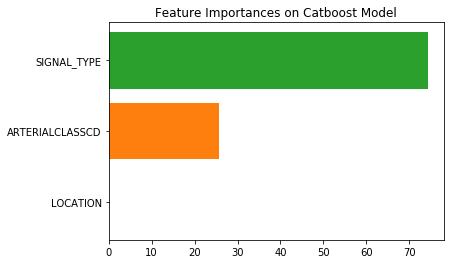

In [11]:
fig, ax = plt.subplots()
for i, feat in enumerate(model_df.columns):
    ax.barh(feat, width=np.mean([f[i] for f in feat_importances]))
ax.set_title('Feature Importances on Catboost Model')
;

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

Text(0.5, 1.0, 'Average Number of Collisions at each Seattle Signal Type')

''

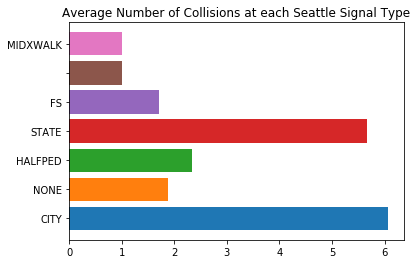

In [12]:
signal_types = [signal_type for signal_type in model_df.SIGNAL_TYPE.unique()]
collisions = [y[model_df.SIGNAL_TYPE == signal_type].mean() for signal_type in signal_types]

fig, ax = plt.subplots()
for st, col in zip(signal_types, collisions):
    ax.barh(st, col)
ax.set_title('Average Number of Collisions at each Seattle Signal Type')
;